In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from IPython import display
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.sparse.linalg
import math



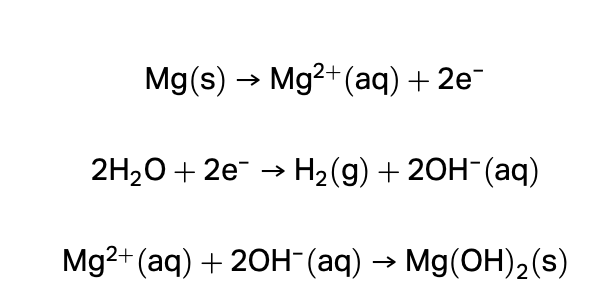

In [3]:
from IPython import display
display.Image("./PaperRxns.png")

The chemical species $\alpha$ involved in this system of reactions are $Mg, Mg^{2+}, e^-, H_2 O, H_2, OH^-, $ and $Mg(OH)_2$, therefore yielding 7 chemical species $\alpha_0$ through $\alpha_6$. 


The system of reactions to be solved will be represented by the `Reactions` array which has `reaction` as its elements. Every `reaction` is in turn an array consisting of:

$\;\;\;\;\;\;$ **I $\,$ -** The reactant species indexes `reac`  coupled with their coefficients `reac_coef` and orders `reac_order` as: `reacs = [reac, reac_coeff, reac_order]`. 

$\;\;\;\;\;\;$ **II -** The products species indexes `prod`  coupled with their coefficients `prod_coef` and orders `prod_order` as: `prods = [prod, prod_coeff, prod_order]`. 

$\;\;\;\;\;\;$ **III-** Forward and reverse reaction rates stored as : `rates = [k_f, k_r]`. 

$\;\;\;\;\;\;$ *Note :* If there is no reverse reaction, the user or program should set `k_r = 0`.

such that `reaction = [reacs, prods, rates]`. The array holding all reactions then becomes `Reactions = [reaction`$_1$ `, reaction`$_2$ `, ` $ ... $ `, reaction`$_{final}$ `]`

<br>

Below is an example implementation of setting the input for the above reactions:


## Example 1 : `Reactions` Initialization

In [4]:
# To begin, define the chemical species. 
alpha_names = ['Mg', 'Mg2+', 'e-', 'H2O', 'H2', 'OH-', 'Mg(OH)2'] # dummy variable to help visualize the function
alpha_index = [  0 ,   1   ,  2  ,   3  ,   4 ,   5  ,     6    ] # alpha index for n_alpha use

# Three reactions : reaction_1, reaction_2, reaction_3
    # For reaction_1
reac_1 = [0] # alpha_index corresponding to the species, here Mg
reac_coef_1 = [1] # coefficients of reactants, here 1 * Mg
reac_order_1 = reac_coef_1 # assumed same as coefficients
reacs_1 = [reac_1, reac_coef_1, reac_order_1]
prod_1 = [1, 2] # alpha_index corresponding to the species, here Mg2+ and e-
prod_coef_1 = [1, 2] # coefficients of reactants, here 1 * Mg2+ and 2 * e-
prod_order_1 = prod_coef_1 # assumed same as coefficients
prods_1 = [prod_1, prod_coef_1, prod_order_1]
k_f_1 = 0.1 # some random rate for now
k_r_1 = 0 # no reverse reaction
rates_1 = [k_f_1, k_r_1]
reaction_1 = [reacs_1, prods_1, rates_1] # reaction = [reacs, prods, rates]
    # For reaction_2
reac_2 = [2, 3] # alpha_index corresponding to the species, here e- and H2O
reac_coef_2 = [2, 2] # coefficients of reactants, here 2 * e- and 2 * H2O
reac_order_2 = reac_coef_2 # assumed same as coefficients
reacs_2 = [reac_2, reac_coef_2, reac_order_2]
prod_2 = [4, 5] # alpha_index corresponding to the species, here H2 and OH-
prod_coef_2 = [1, 2] # coefficients of reactants, here 1 * H2 and 2 * OH-
prod_order_2 = prod_coef_2 # assumed same as coefficients
prods_2 = [prod_2, prod_coef_2, prod_order_2]
k_f_2 = 0.05 # some random rate for now
k_r_2 = 0 # no reverse reaction
rates_2 = [k_f_2, k_r_2]
reaction_2 = [reacs_2, prods_2, rates_2] # reaction = [reacs, prods, rates]    
    # For reaction_3
reac_3 = [1, 5] # alpha_index corresponding to the species, here Mg2+ and OH-
reac_coef_3 = [1, 2] # coefficients of reactants, here 1 * Mg2+ and 2 * OH-
reac_order_3 = reac_coef_3 # assumed same as coefficients
reacs_3 = [reac_3, reac_coef_3, reac_order_3]
prod_3 = [6] # alpha_index corresponding to the species, here Mg(OH)2
prod_coef_3 = [1] # coefficients of reactants, here 1 * Mg(OH)2
prod_order_3 = prod_coef_3 # assumed same as coefficients
prods_3 = [prod_3, prod_coef_3, prod_order_3]
k_f_3 = 0.025 # some random rate for now
k_r_3 = 0 # no reverse reaction
rates_3 = [k_f_3, k_r_3]
reaction_3 = [reacs_3, prods_3, rates_3] # reaction = [reacs, prods, rates]

# Set the Reactions 
Reactions = [reaction_1, reaction_2, reaction_3]



<br>

## Example 2 : Setup for 2D Implementation

The concentrations of all species will be stored as $n_\alpha \equiv$ `n_alpha` of shape $\alpha \times N_x \times N_y$ where $\alpha$ is the number of chemical species and $N_x$ and $N_y$ are the horizontal and vertical number of grid divisions. 


In [5]:
# initialize n_alpha
alpha_num = 7 # seven chemical species involved in the three reactions above
Nx = 31
Ny = 31
n_alpha = np.zeros((alpha_num, Nx, Ny))

# initially, let the system consist of an Mg block surrounded by water where 
    # corrosion product formation rate and location ( Mg(OH)2 ) is of interest
N_mid = int((Nx - 1)/2)
n_alpha[0, N_mid-5:N_mid+5, N_mid-5:N_mid+5] = 10 * np.ones((10, 10)) # 0 index represents Mg 
                                                                 # created a Mg square
n_alpha[3] = 10 * np.ones((Nx, Ny)) # 3 index represents H2O, H2O present across the domain currently
n_alpha[3, N_mid-4:N_mid+4, N_mid-4:N_mid+4] = np.zeros((8, 8)) # removed H2O from Mg square
                

<br>

## Example 3 : Algorithm 2, implementation (2D & 3D compatible) 

Note that the implementation below completes a single time-step. While this time-step is compatible with the CPFM algorithm iplementation in 2D and 3D, the actual function will not update `n_alpha` after a time-step but will instead pass the chemical reaction contribution to the temporal rate of change of `n_alpha`. In other words, CPFM has 

$$\frac{\partial}{\partial t} {\bf n_\alpha} = - \nabla \cdot {\bf J_\alpha} \equiv \left( \frac{\partial}{\partial t} {\bf n_\alpha} \right)_{CPFM} $$

The addition of chemical reactions will add the term

$$ \left( \frac{\partial}{\partial t} {\bf n_\alpha} \right)_{rxns} = \sum_{i = 0}^{N_{rxns}} \left( {\bf r_{f, \alpha, i}} - {\bf r_{r, \alpha, i}} \right) $$ where ${\bf r_{f, \alpha, i}} - {\bf r_{r, \alpha, i}}$ is the difference between the forward and backward reaction rates for species $\alpha$ of reaction $i$ where $N_{rxns}$ is the number of reactions to be simulated. 

Thus, the complemented rate of change for $n_\alpha$ becomes:

$$ \frac{\partial}{\partial t} {\bf n_\alpha} := \left( \frac{\partial}{\partial t} {\bf n_\alpha} \right)_{CPFM} + \left( \frac{\partial}{\partial t} {\bf n_\alpha} \right)_{rxns} = - \nabla \cdot {\bf J_\alpha} + \sum_{i = 0}^{N_{rxns}} \left( {\bf r_{f, \alpha, i}} - {\bf r_{r, \alpha, i}} \right) $$

<br>

For the reversible reaction $a A + b B \longleftrightarrow c \, C + d D$ and respective reaction orders $\lambda_A, \lambda_B, \lambda_C$ and $\lambda_D$, the computationally least expensive way to solve for all rates for the respective species involved, one method is calculating and then normalizing the rate of change of $n_A$:

$$ \frac{\partial}{\partial t} {\bf n_A} = - k_f {\bf n_A}^{\lambda_A} \, {\bf n_B}^{\lambda_B} + k_r {\bf n_C}^{\lambda_C} \, {\bf n_D}^{\lambda_D} = {\bf r_A} , \quad \frac{\partial}{\partial t} {\bf n_B} = \frac{b}{a} {\bf r_A}, \quad \frac{\partial}{\partial t} {\bf n_C} = - \frac{c}{a} {\bf r_A} , \quad \frac{\partial}{\partial t} {\bf n_D} = - \frac{d}{a} {\bf r_A}$$

<br>

*Note :* A system of chemical reactions requires similar considerations for every reaction in the system. 

In [6]:
# initialize the reaction n_alpha derivative contribution
dn_dt_rxns = np.zeros(np.shape(n_alpha)) # same shape as alpha

# iterate over reactions making up the system
for reaction in Reactions: 
    
    # obtain reactant, product, and rate information
    reacs, prods, rates = reaction
    
    # obtain reactant species' index and coefficient
    reac, reac_coef, reac_order = reacs
    # obtain product species' index and coefficient
    prod, prod_coef, prod_order = prods
    # obtain reaction rates
    k_f, k_r = rates
    
    # initialize the forward and reverse n_alpha ** (coefficient of n_alpha) 
        # multiplication to have shape (Nx, Ny)
    mult_fwd = np.ones(np.shape(n_alpha)[1:]) # remove alpha from (alpha, Nx, Ny)
    mult_rev = np.ones(np.shape(n_alpha)[1:]) # remove alpha from (alpha, Nx, Ny)
    
    # iterate over reactants 
    for i in range(len(reac)):
        # calculate forward contribution
        mult_fwd *= n_alpha[reac[i]]**reac_order[i]
    
    # if there is no reverse reaction
    if (k_r == 0):
        # do not calculate reverse contribution
        mult_rev = np.zeros(np.shape(n_alpha)[1:]) # set reverse contribution to 0s
    # if the reaction is reversible
    else: 
        # iterate over products 
        for i in range(len(prod)):
            # calculate reverse contribution
            mult_rev *= n_alpha[prod[i]]**prod_order[i]
            
    # calculate the dn_alpha / dt reaction contribution
    # iterate over reactants 
    for i in range(len(reac)):
        # normalize rates based on first reactant
        if (i == 0):
            # calculate the rate of the first reactant
            rate_normalized = - k_f * mult_fwd + k_r * mult_rev
            dn_dt_rxns[reac[0]] += rate_normalized
            print(alpha_names[reac[i]], ',', alpha_index[reac[i]], ' \t,', np.sum(dn_dt_rxns[reac[i]]))
        else:
            # normalized w.r.t. first reactant
            dn_dt_rxns[reac[i]] += (reac_coef[i] / reac_coef[0]) * rate_normalized
            print(alpha_names[reac[i]], ',', alpha_index[reac[i]], ' \t,', np.sum(dn_dt_rxns[reac[i]]))
    # iterate over products
    for i in range(len(prod)):
        # normalized w.r.t. first reactant
        dn_dt_rxns[prod[i]] += -(prod_coef[i] / reac_coef[0]) * rate_normalized
        
# And now dn_dt_rxns has been updated for. Remember that after returning this
    # reaction contribution, the n_alpha_Update fxns would require scaling by
    # dt (∆t)

Mg , 0  	, -100.0
e- , 2  	, 200.0
H2O , 3  	, 0.0
Mg2+ , 1  	, 100.0
OH- , 5  	, 0.0


Let us take another time-step for an arbitrary $\Delta t$ after updating `n_alpha`. 

In [7]:
# take n_alpha time-step
dt = 0.1
n_alpha += dt * dn_dt_rxns

# initialize the reaction n_alpha derivative contribution
dn_dt_rxns = np.zeros(np.shape(n_alpha)) # same shape as alpha

# iterate over reactions making up the system
for reaction in Reactions: 
    
    # obtain reactant, product, and rate information
    reacs, prods, rates = reaction
    
    # obtain reactant species' index, coefficients, and orders
    reac, reac_coef, reac_order = reacs
    # obtain product species' index, coefficients, and orders
    prod, prod_coef, prod_order = prods
    # obtain reaction rates
    k_f, k_r = rates
    
    # initialize the forward and reverse n_alpha ** (coefficient of n_alpha) 
        # multiplication to have shape (Nx, Ny)
    mult_fwd = np.ones(np.shape(n_alpha)[1:]) # remove alpha from (alpha, Nx, Ny)
    mult_rev = np.ones(np.shape(n_alpha)[1:]) # remove alpha from (alpha, Nx, Ny)
    
    # iterate over reactants 
    for i in range(len(reac)):
        # calculate forward contribution
        mult_fwd *= n_alpha[reac[i]]**reac_coef[i]
    
    # if there is no reverse reaction
    if (k_r == 0):
        # do not calculate reverse contribution
        mult_rev = np.zeros(np.shape(n_alpha)[1:]) # set reverse contribution to 0s
    # if the reaction is reversible
    else: 
        # iterate over products 
        for i in range(len(prod)):
            # calculate reverse contribution
            mult_rev *= n_alpha[prod[i]]**prod_coef[i]
            
    # calculate the dn_alpha / dt reaction contribution
    # iterate over reactants 
    for i in range(len(reac)):
        # normalize rates based on first reactant
        if (i == 0):
            # calculate the rate of the first reactant
            rate_normalized = - k_f * mult_fwd + k_r * mult_rev
            dn_dt_rxns[reac[0]] += rate_normalized
            print(alpha_names[reac[i]], ',', alpha_index[reac[i]], ' \t,', np.sum(dn_dt_rxns[reac[i]]))
        else:
            # normalized w.r.t. first reactant
            dn_dt_rxns[reac[i]] += (reac_coef[i] / reac_coef[0]) * rate_normalized
            print(alpha_names[reac[i]], ',', alpha_index[reac[i]], ' \t,', np.sum(dn_dt_rxns[reac[i]]))
    # iterate over products
    for i in range(len(prod)):
        # normalized w.r.t. first reactant
        dn_dt_rxns[prod[i]] += -(prod_coef[i] / reac_coef[0]) * rate_normalized
        

Mg , 0  	, -99.0
e- , 2  	, 190.8
H2O , 3  	, -7.200000000000003
Mg2+ , 1  	, 99.0
OH- , 5  	, 7.200000000000003


In [8]:
type(reac[0])

int

<br>

## Example 4 : Algorithm 2, function implementation (2D & 3D compatible) 


In [9]:
def dndt_rxn_contribution(n_alpha, Reactions):
    """
    Calculates the temporal derivative dn_alpha/dt subject to a system of chemical
    reactions. All reactions are assumed to be reversible. For reactions that do not
    have a reverse component, the reverse rate k_r = 0
    * The function is compatible with 2D and 3D CPFM simulations. 
    * The function relies on simple NumPy functions and thus is ready for the C++ 
    implementation.
    Inputs : n_alpha (float array), the alpha concentration / density 3D or 4D
                 array with dimensions (alpha) x (Domain Size)
             Reactions (list), includes system of reactions information, make class
                 reaction (list), includes information for one reaction
                     reacs (list), includes reactant information
                         reac (int list), list of reactant species alpha index
                         reac_coef (float list), list of reactant species coefficients
                         reac_order (float list), list of reactant species rate order
                     prods (list), includes product information
                         prod (int list), list of product species alpha index
                         prod_coef (float list), list of product species coefficients
                         prod_order (float list), list of product species rate order
                     rates (float list), list of forward and reverse reaction rates
                         k_f (float), forward reaction rate
                         k_r (float), reverse reaction rate
    Outputs : dn_dt_rxns (float array), the chemical reaction induced dn_alpha/dt
                  array with dimensions identical to n_alpha
    """
    
    # initialize the reaction n_alpha derivative contribution
    dn_dt_rxns = np.zeros(np.shape(n_alpha)) # same shape as alpha

    # iterate over reactions making up the system
    for reaction in Reactions: 
    
        # obtain reactant, product, and rate information
        reacs, prods, rates = reaction
    
        # obtain reactant species' index, coefficients, and orders
        reac, reac_coef, reac_order = reacs
        # obtain product species' index, coefficients, and orders
        prod, prod_coef, prod_order = prods
        # obtain reaction rates
        k_f, k_r = rates
    
        # initialize the forward and reverse n_alpha ** (coefficient of n_alpha) 
            # multiplication to have shape (Nx, Ny)
        mult_fwd = np.ones(np.shape(n_alpha)[1:]) # remove alpha from (alpha, Nx, Ny)
        mult_rev = np.ones(np.shape(n_alpha)[1:]) # remove alpha from (alpha, Nx, Ny)
    
        # iterate over reactants 
        for i in range(len(reac)):
            # calculate forward contribution
            mult_fwd *= n_alpha[reac[i]]**reac_coef[i]
    
        # if there is no reverse reaction
        if (k_r == 0):
            # do not calculate reverse contribution
            mult_rev = np.zeros(np.shape(n_alpha)[1:]) # set reverse contribution to 0s
        # if the reaction is reversible
        else: 
            # iterate over products 
            for i in range(len(prod)):
                # calculate reverse contribution
                mult_rev *= n_alpha[prod[i]]**prod_coef[i]
            
        # calculate the dn_alpha / dt reaction contribution
        # iterate over reactants 
        for i in range(len(reac)):
            # 1st reactant
            if (i == 0):
                # calculate the rate of the first reactant
                rate_normalized = - k_f * mult_fwd + k_r * mult_rev
                dn_dt_rxns[reac[0]] += rate_normalized
            else:
                # normalized w.r.t. first reactant
                dn_dt_rxns[reac[i]] += (reac_coef[i] / reac_coef[0]) * rate_normalized
        # iterate over products
        for i in range(len(prod)):
            # normalized w.r.t. first reactant
            dn_dt_rxns[prod[i]] += -(prod_coef[i] / reac_coef[0]) * rate_normalized
        
    return dn_dt_rxns
    

The dummy function below is meant to replace the `n_alpha_Update_2D()` and `iteration_Forward_2D()` CPFM functions, but performs iterations such that 

$$ \frac{\partial}{\partial t} {\bf n_\alpha} := \left( \frac{\partial}{\partial t} {\bf n_\alpha} \right)_{rxns} = \sum_{i = 0}^{N_{rxns}} \left( {\bf r_{f, \alpha, i}} - {\bf r_{r, \alpha, i}} \right) $$

instead of the future version where both the CPFM and reaction contributions are consolidated as:

$$ \frac{\partial}{\partial t} {\bf n_\alpha} := \left( \frac{\partial}{\partial t} {\bf n_\alpha} \right)_{CPFM} + \left( \frac{\partial}{\partial t} {\bf n_\alpha} \right)_{rxns} = - \nabla \cdot {\bf J_\alpha} + \sum_{i = 0}^{N_{rxns}} \left( {\bf r_{f, \alpha, i}} - {\bf r_{r, \alpha, i}} \right) $$

The challenges regarding this approach relate to finding the appropriate rate constants via sufficient experimentation. 


In [10]:
def chemical_reaction(dt, t_max, n_alpha, Reactions):
    
    t_cur = 0
    
    while (t_cur < t_max):
        
        dn_dt_rxns = dndt_rxn_contribution(n_alpha, Reactions)
        
        n_alpha += dt *  dn_dt_rxns
        
        # replace undershoots
        n_alpha = np.where(n_alpha<0, 0, n_alpha)

        t_cur += dt
        
    return n_alpha

### Qualitative Check via Plotting

In [11]:
dt = 0.1
t_max = 100

n_alpha = chemical_reaction(dt, t_max, n_alpha, Reactions)

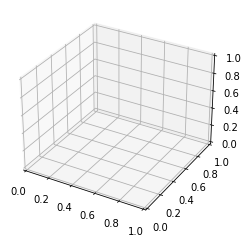

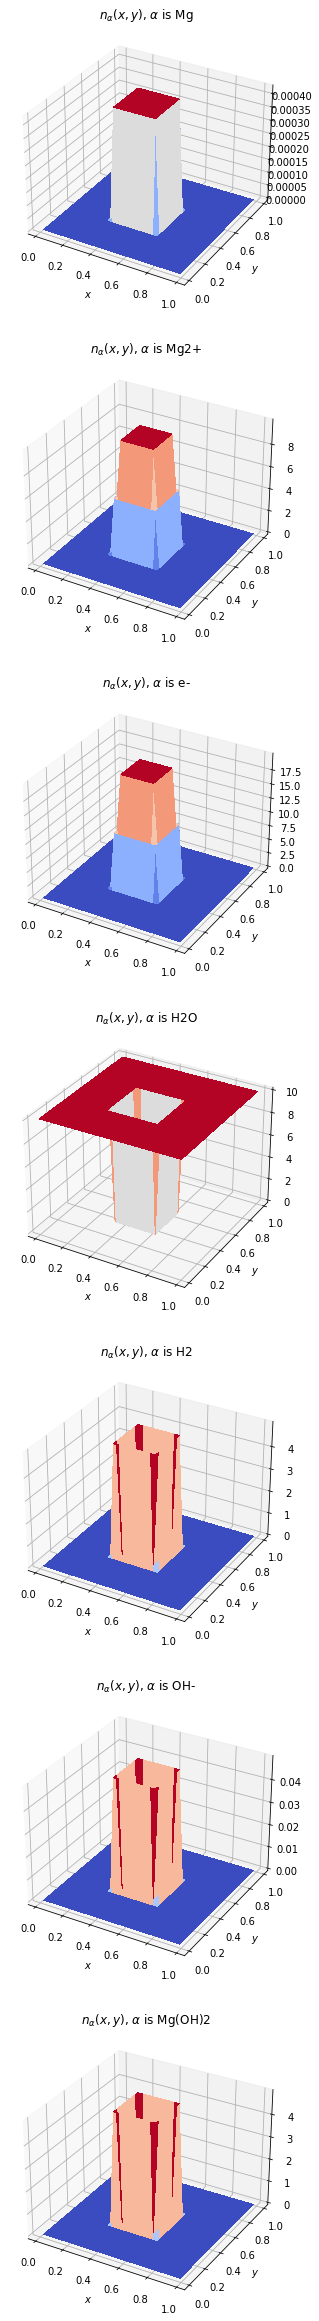

In [12]:
a = 1.0/Nx
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


fig = plt.figure(figsize=(20, 42))

for i in range(len(alpha_names)):
    
    ax = fig.add_subplot(len(alpha_names), 1, i+1, projection='3d')
    ax.plot_surface(xx, yy, n_alpha[i], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_title(r'$n_\alpha(x,y)$, $\alpha$ is {}'.format(alpha_names[i]))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    
plt.show()     


### A Less Even Geometry

In [13]:
# initialize n_alpha
alpha_num = 7 # seven chemical species involved in the three reactions above
Nx = 31
Ny = 31
n_alpha = np.zeros((alpha_num, Nx, Ny))

# initially, let the system consist of some irregular Mg block surrounded by water where 
    # corrosion product formation rate and location ( Mg(OH)2 ) is of interest
    
n_alpha[0, N_mid-10:N_mid+10, N_mid-10:N_mid+10] = 10 * np.ones((20, 20)) # 0 index represents Mg 
                                                                          # created a Mg square
x_axis = np.linspace(0,1,20)
X_axis, Y_axis = np.meshgrid(x_axis, x_axis)
n_alpha[0, N_mid-10:N_mid+10, N_mid-10:N_mid+10] += np.sin(5 * np.pi * X_axis) * np.cos(8 * np.pi * Y_axis)
                                                                          # add the disturbance
n_alpha[3] = 10 * np.ones((Nx, Ny)) # 3 index represents H2O, H2O present across the domain currently
n_alpha[3, N_mid-10:N_mid+10, N_mid-10:N_mid+10] = np.ones((20, 20)) - np.sin(5 * np.pi * X_axis) * np.cos(8 * np.pi * Y_axis)
                                                                            # removed H2O from Mg square
                

***Initial View***

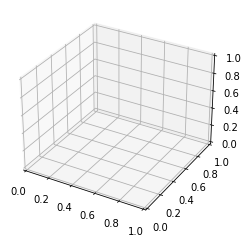

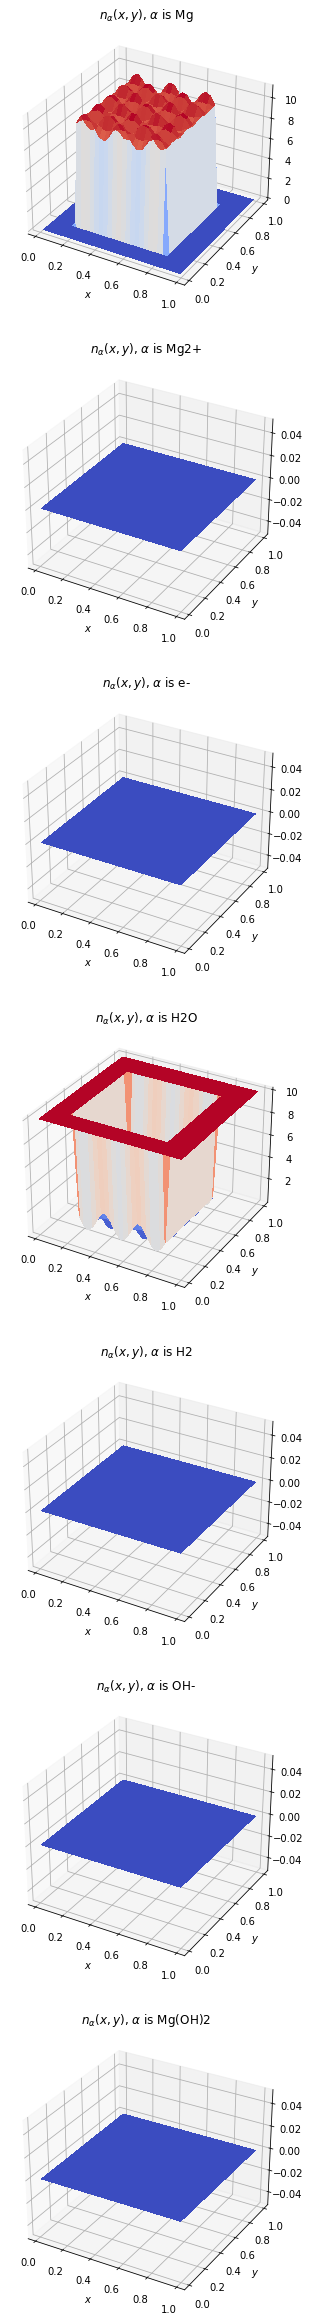

In [14]:
a = 1.0/Nx
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


fig = plt.figure(figsize=(20, 42))

for i in range(len(alpha_names)):
    
    ax = fig.add_subplot(len(alpha_names), 1, i+1, projection='3d')
    ax.plot_surface(xx, yy, n_alpha[i], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_title(r'$n_\alpha(x,y)$, $\alpha$ is {}'.format(alpha_names[i]))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    
plt.show()     


In [15]:
dt = 0.1
t_max = 100

n_alpha = chemical_reaction(dt, t_max, n_alpha, Reactions)

***After Run***

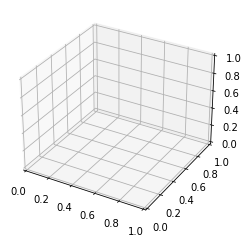

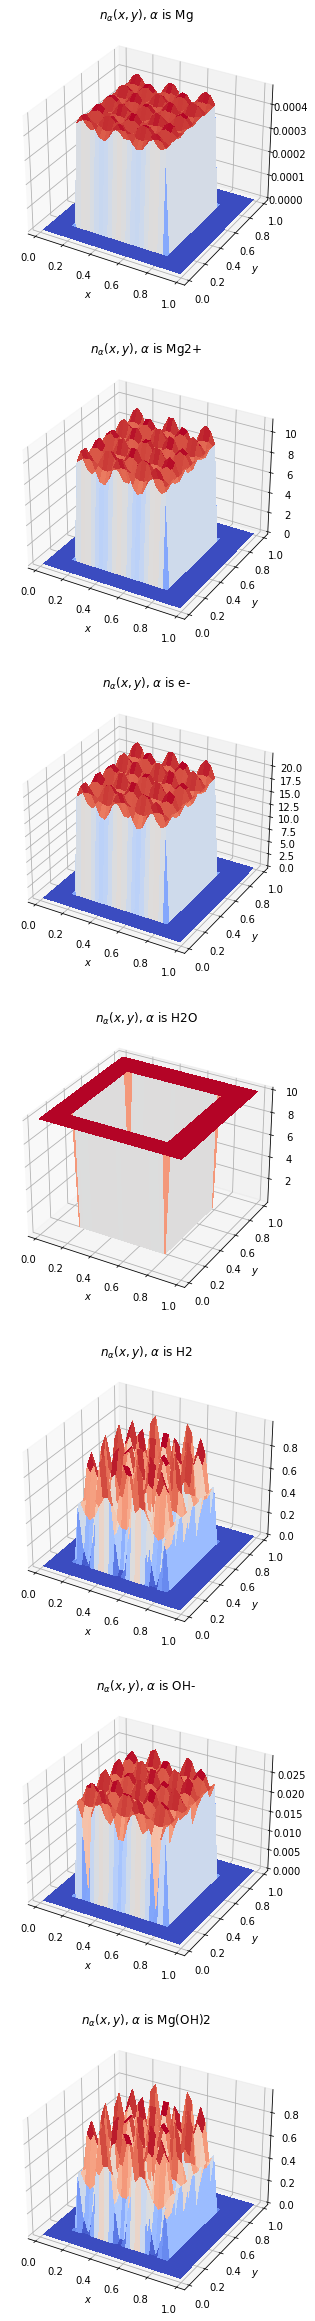

In [16]:
a = 1.0/Nx
x_ax = np.arange(a/2, 1 - a/2 + 1e-15, a)
X = x_ax
Y = x_ax

xx, yy = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


fig = plt.figure(figsize=(20, 42))

for i in range(len(alpha_names)):
    
    ax = fig.add_subplot(len(alpha_names), 1, i+1, projection='3d')
    ax.plot_surface(xx, yy, n_alpha[i], cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    ax.set_title(r'$n_\alpha(x,y)$, $\alpha$ is {}'.format(alpha_names[i]))
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    
plt.show()     



# Next Steps (?)

***I -*** Explore the effects of the phase $\theta$ on the reaction rate.  
***II-*** Is there a need to use phase variables for each chemical species to accurately represent the reaction kinetics? If so, full integration into CPFM could be achieved by replacing `theta` by a `theta_alpha` of size $\alpha \times$ *(Domain Size)*, decoupling the way phase is currently handled to an individual per chemical species basis.

Whithin this framework, for these hypothetical phases $\theta_\alpha$, it is possible to view the phase as a fraction of solids and liquids since $0 \leq \theta_\alpha \leq 1$ where $1$ represents pure liquid and $0$ represents pure solid. 

Reaction rates use $n_\alpha$ to determine *How much building material do we have & where?* (spatial awareness built-in)

Reaction rates could use $\theta_\alpha$ to determine *How much (what fraction) of the building material HERE (at this location) is useful?* (phase awareness)

<br>

**e.g.** For the $1^{st}$ reaction of the system ( $ Mg_{(s)} \rightarrow Mg_{(aq)}^{2+} + 2 e^- $ ), the reaction requires Mg to be solid, and it should hold true that as $\theta_{Mg} \rightarrow 0$, the reaction rate $|r_{Mg}| \rightarrow max\left(|r_{Mg}|\right)$. This could be implemented as :

$ \dot{\bf n}_{Mg} = - k_f {\bf n}_{Mg}^{\lambda_{Mg}} \left( 1 - \theta_{Mg} \right) $ instead of $ \dot{\bf n}_{Mg} = - k_f {\bf n}_{Mg}^{\lambda_{Mg}} $

Similarly, if a reactant, reactant $X$ is aqueous or liquid, then it should hold true that as $\theta_X \rightarrow 1$, the reaction rate $|r_X| \rightarrow max\left(|r_X|\right)$. This could be implemented as :

$ \dot{\bf n}_X = - k_f {\bf n}_{X}^{\lambda_{X}} \theta_{X} $

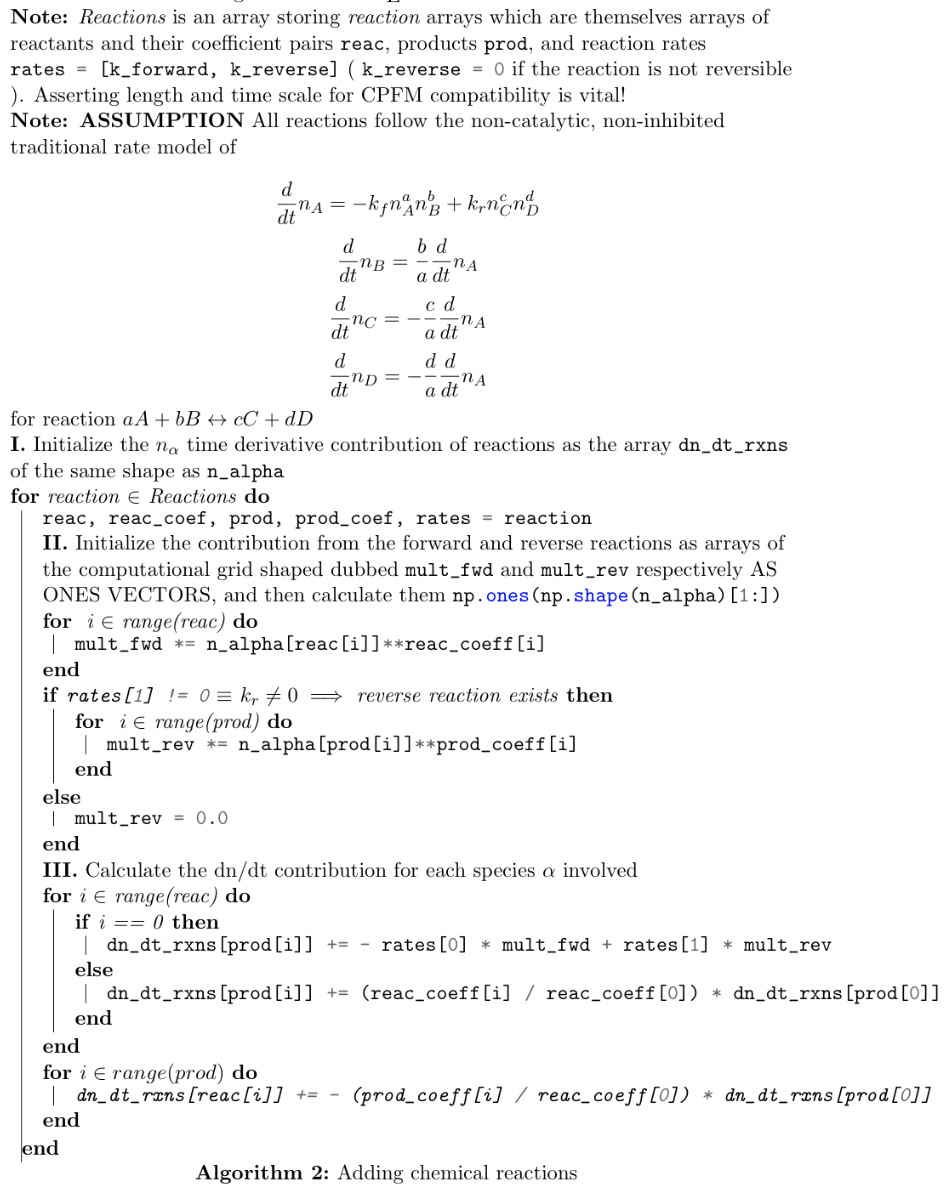

In [17]:
from IPython import display
display.Image("./AddingChemRxns.png")